In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [8]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    dQs = tf.reshape(dQs, shape=[-1])
    aloss2 += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [9]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [11]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:1.3768 dloss:0.9183 aloss2:0.9418 exploreP:0.9985
Episode:1 meanR:18.5000 R:22.0000 rate:0.0440 aloss:1.3741 dloss:0.9254 aloss2:0.9323 exploreP:0.9963
Episode:2 meanR:17.3333 R:15.0000 rate:0.0300 aloss:1.3770 dloss:0.9139 aloss2:0.9618 exploreP:0.9949
Episode:3 meanR:17.5000 R:18.0000 rate:0.0360 aloss:1.3741 dloss:0.9645 aloss2:1.0731 exploreP:0.9931
Episode:4 meanR:17.4000 R:17.0000 rate:0.0340 aloss:1.3859 dloss:0.9168 aloss2:1.0386 exploreP:0.9914
Episode:5 meanR:18.8333 R:26.0000 rate:0.0520 aloss:1.3775 dloss:0.9207 aloss2:1.0244 exploreP:0.9889
Episode:6 meanR:18.1429 R:14.0000 rate:0.0280 aloss:1.3801 dloss:0.9491 aloss2:1.0222 exploreP:0.9875
Episode:7 meanR:17.2500 R:11.0000 rate:0.0220 aloss:1.3720 dloss:0.8617 aloss2:1.0698 exploreP:0.9864
Episode:8 meanR:16.8889 R:14.0000 rate:0.0280 aloss:1.3762 dloss:0.8794 aloss2:1.0364 exploreP:0.9851
Episode:9 meanR:16.9000 R:17.0000 rate:0.0340 aloss:1.3769 dloss:0.8923 aloss2:1.0

Episode:80 meanR:21.5309 R:24.0000 rate:0.0480 aloss:1.4191 dloss:0.4837 aloss2:4.2833 exploreP:0.8416
Episode:81 meanR:21.5488 R:23.0000 rate:0.0460 aloss:1.4162 dloss:0.4885 aloss2:4.2994 exploreP:0.8397
Episode:82 meanR:21.5422 R:21.0000 rate:0.0420 aloss:1.4116 dloss:0.4828 aloss2:4.2629 exploreP:0.8379
Episode:83 meanR:21.4405 R:13.0000 rate:0.0260 aloss:1.4221 dloss:0.4785 aloss2:4.4501 exploreP:0.8368
Episode:84 meanR:21.3765 R:16.0000 rate:0.0320 aloss:1.4282 dloss:0.4788 aloss2:4.5316 exploreP:0.8355
Episode:85 meanR:21.2791 R:13.0000 rate:0.0260 aloss:1.4262 dloss:0.4689 aloss2:4.4635 exploreP:0.8344
Episode:86 meanR:21.3103 R:24.0000 rate:0.0480 aloss:1.4206 dloss:0.4746 aloss2:4.6490 exploreP:0.8325
Episode:87 meanR:21.2500 R:16.0000 rate:0.0320 aloss:1.4222 dloss:0.4904 aloss2:4.4720 exploreP:0.8311
Episode:88 meanR:21.2022 R:17.0000 rate:0.0340 aloss:1.4276 dloss:0.4646 aloss2:4.7971 exploreP:0.8298
Episode:89 meanR:21.1889 R:20.0000 rate:0.0400 aloss:1.4282 dloss:0.4563 

Episode:159 meanR:22.5900 R:31.0000 rate:0.0620 aloss:1.4583 dloss:0.3960 aloss2:8.6850 exploreP:0.6979
Episode:160 meanR:22.5600 R:12.0000 rate:0.0240 aloss:1.4395 dloss:0.3768 aloss2:8.8313 exploreP:0.6970
Episode:161 meanR:23.1100 R:67.0000 rate:0.1340 aloss:1.4624 dloss:0.3807 aloss2:8.6922 exploreP:0.6925
Episode:162 meanR:22.9100 R:14.0000 rate:0.0280 aloss:1.4480 dloss:0.3829 aloss2:8.9492 exploreP:0.6915
Episode:163 meanR:22.9600 R:17.0000 rate:0.0340 aloss:1.4672 dloss:0.3809 aloss2:8.7054 exploreP:0.6903
Episode:164 meanR:23.0700 R:28.0000 rate:0.0560 aloss:1.4611 dloss:0.3845 aloss2:8.7508 exploreP:0.6884
Episode:165 meanR:23.1800 R:27.0000 rate:0.0540 aloss:1.4519 dloss:0.3819 aloss2:8.8765 exploreP:0.6866
Episode:166 meanR:23.2400 R:19.0000 rate:0.0380 aloss:1.4424 dloss:0.3811 aloss2:8.7192 exploreP:0.6853
Episode:167 meanR:23.3600 R:28.0000 rate:0.0560 aloss:1.4681 dloss:0.3731 aloss2:8.9378 exploreP:0.6834
Episode:168 meanR:23.6400 R:42.0000 rate:0.0840 aloss:1.4620 dlo

Episode:238 meanR:21.9900 R:20.0000 rate:0.0400 aloss:1.4808 dloss:0.3842 aloss2:8.9881 exploreP:0.5877
Episode:239 meanR:22.0600 R:22.0000 rate:0.0440 aloss:1.5187 dloss:0.3908 aloss2:8.9576 exploreP:0.5864
Episode:240 meanR:22.0900 R:27.0000 rate:0.0540 aloss:1.4737 dloss:0.3681 aloss2:9.0273 exploreP:0.5848
Episode:241 meanR:21.8600 R:16.0000 rate:0.0320 aloss:1.4770 dloss:0.3847 aloss2:9.0347 exploreP:0.5839
Episode:242 meanR:21.8500 R:21.0000 rate:0.0420 aloss:1.4681 dloss:0.3821 aloss2:9.0876 exploreP:0.5827
Episode:243 meanR:21.9900 R:36.0000 rate:0.0720 aloss:1.4693 dloss:0.3796 aloss2:9.0292 exploreP:0.5807
Episode:244 meanR:21.6800 R:12.0000 rate:0.0240 aloss:1.4679 dloss:0.3644 aloss2:9.1084 exploreP:0.5800
Episode:245 meanR:21.7300 R:16.0000 rate:0.0320 aloss:1.4653 dloss:0.3822 aloss2:9.1119 exploreP:0.5791
Episode:246 meanR:21.7400 R:14.0000 rate:0.0280 aloss:1.4894 dloss:0.3790 aloss2:9.1133 exploreP:0.5783
Episode:247 meanR:21.5700 R:12.0000 rate:0.0240 aloss:1.4548 dlo

Episode:317 meanR:21.9800 R:38.0000 rate:0.0760 aloss:1.5014 dloss:0.3875 aloss2:9.1908 exploreP:0.4947
Episode:318 meanR:22.3600 R:51.0000 rate:0.1020 aloss:1.4814 dloss:0.3876 aloss2:9.0984 exploreP:0.4922
Episode:319 meanR:22.4300 R:25.0000 rate:0.0500 aloss:1.4968 dloss:0.3765 aloss2:9.1636 exploreP:0.4910
Episode:320 meanR:22.3600 R:27.0000 rate:0.0540 aloss:1.4998 dloss:0.3813 aloss2:9.1078 exploreP:0.4897
Episode:321 meanR:22.3700 R:17.0000 rate:0.0340 aloss:1.4766 dloss:0.3686 aloss2:9.0760 exploreP:0.4889
Episode:322 meanR:22.4200 R:19.0000 rate:0.0380 aloss:1.5091 dloss:0.3690 aloss2:9.1365 exploreP:0.4880
Episode:323 meanR:22.4700 R:18.0000 rate:0.0360 aloss:1.5269 dloss:0.3621 aloss2:9.1313 exploreP:0.4871
Episode:324 meanR:22.5300 R:33.0000 rate:0.0660 aloss:1.4877 dloss:0.3818 aloss2:9.2151 exploreP:0.4856
Episode:325 meanR:22.7900 R:41.0000 rate:0.0820 aloss:1.4771 dloss:0.3723 aloss2:9.2225 exploreP:0.4836
Episode:326 meanR:22.7900 R:20.0000 rate:0.0400 aloss:1.4672 dlo

Episode:396 meanR:21.6000 R:18.0000 rate:0.0360 aloss:1.5174 dloss:0.3661 aloss2:9.2535 exploreP:0.4190
Episode:397 meanR:21.6300 R:14.0000 rate:0.0280 aloss:1.4537 dloss:0.3675 aloss2:9.2537 exploreP:0.4184
Episode:398 meanR:21.6200 R:18.0000 rate:0.0360 aloss:1.5104 dloss:0.3661 aloss2:9.2765 exploreP:0.4176
Episode:399 meanR:21.7000 R:22.0000 rate:0.0440 aloss:1.4901 dloss:0.3982 aloss2:9.2680 exploreP:0.4168
Episode:400 meanR:21.6700 R:21.0000 rate:0.0420 aloss:1.5039 dloss:0.3582 aloss2:9.2826 exploreP:0.4159
Episode:401 meanR:21.7300 R:26.0000 rate:0.0520 aloss:1.4990 dloss:0.3697 aloss2:9.2891 exploreP:0.4148
Episode:402 meanR:21.7800 R:21.0000 rate:0.0420 aloss:1.4992 dloss:0.3831 aloss2:9.2841 exploreP:0.4140
Episode:403 meanR:21.7600 R:17.0000 rate:0.0340 aloss:1.5002 dloss:0.3685 aloss2:9.2559 exploreP:0.4133
Episode:404 meanR:21.5100 R:16.0000 rate:0.0320 aloss:1.4897 dloss:0.3939 aloss2:9.2719 exploreP:0.4127
Episode:405 meanR:21.5600 R:22.0000 rate:0.0440 aloss:1.4922 dlo

Episode:475 meanR:18.0400 R:12.0000 rate:0.0240 aloss:1.5171 dloss:0.3797 aloss2:9.2021 exploreP:0.3646
Episode:476 meanR:18.0500 R:22.0000 rate:0.0440 aloss:1.5417 dloss:0.3555 aloss2:9.2367 exploreP:0.3638
Episode:477 meanR:17.9600 R:14.0000 rate:0.0280 aloss:1.5192 dloss:0.3771 aloss2:9.2415 exploreP:0.3633
Episode:478 meanR:17.9400 R:11.0000 rate:0.0220 aloss:1.5059 dloss:0.3776 aloss2:9.3055 exploreP:0.3629
Episode:479 meanR:17.8600 R:16.0000 rate:0.0320 aloss:1.5171 dloss:0.3657 aloss2:9.2638 exploreP:0.3624
Episode:480 meanR:17.9100 R:16.0000 rate:0.0320 aloss:1.5368 dloss:0.3763 aloss2:9.2662 exploreP:0.3618
Episode:481 meanR:18.0100 R:30.0000 rate:0.0600 aloss:1.5114 dloss:0.3677 aloss2:9.2955 exploreP:0.3608
Episode:482 meanR:17.9900 R:13.0000 rate:0.0260 aloss:1.5053 dloss:0.3654 aloss2:9.3178 exploreP:0.3603
Episode:483 meanR:18.0300 R:19.0000 rate:0.0380 aloss:1.4731 dloss:0.3599 aloss2:9.0155 exploreP:0.3596
Episode:484 meanR:18.0800 R:18.0000 rate:0.0360 aloss:1.5426 dlo

Episode:554 meanR:18.8100 R:19.0000 rate:0.0380 aloss:1.5184 dloss:0.3759 aloss2:9.2577 exploreP:0.3155
Episode:555 meanR:18.8600 R:21.0000 rate:0.0420 aloss:1.5195 dloss:0.3621 aloss2:9.3264 exploreP:0.3149
Episode:556 meanR:18.8500 R:21.0000 rate:0.0420 aloss:1.5155 dloss:0.3602 aloss2:9.3256 exploreP:0.3142
Episode:557 meanR:18.9000 R:17.0000 rate:0.0340 aloss:1.5025 dloss:0.3704 aloss2:9.3330 exploreP:0.3137
Episode:558 meanR:18.9000 R:20.0000 rate:0.0400 aloss:1.4908 dloss:0.3861 aloss2:9.3006 exploreP:0.3131
Episode:559 meanR:18.8900 R:14.0000 rate:0.0280 aloss:1.4993 dloss:0.3590 aloss2:9.3052 exploreP:0.3127
Episode:560 meanR:19.0300 R:26.0000 rate:0.0520 aloss:1.4998 dloss:0.3778 aloss2:9.3094 exploreP:0.3119
Episode:561 meanR:19.0500 R:22.0000 rate:0.0440 aloss:1.4939 dloss:0.3643 aloss2:9.3181 exploreP:0.3112
Episode:562 meanR:19.0200 R:24.0000 rate:0.0480 aloss:1.5022 dloss:0.3801 aloss2:9.3295 exploreP:0.3105
Episode:563 meanR:19.0700 R:19.0000 rate:0.0380 aloss:1.5247 dlo

Episode:633 meanR:21.5000 R:21.0000 rate:0.0420 aloss:1.5179 dloss:0.3736 aloss2:9.3411 exploreP:0.2677
Episode:634 meanR:21.3900 R:16.0000 rate:0.0320 aloss:1.5080 dloss:0.3632 aloss2:9.3776 exploreP:0.2672
Episode:635 meanR:21.5400 R:28.0000 rate:0.0560 aloss:1.5207 dloss:0.3574 aloss2:9.3557 exploreP:0.2665
Episode:636 meanR:21.5100 R:17.0000 rate:0.0340 aloss:1.5168 dloss:0.3698 aloss2:9.4062 exploreP:0.2661
Episode:637 meanR:21.5400 R:19.0000 rate:0.0380 aloss:1.4936 dloss:0.3704 aloss2:9.3928 exploreP:0.2656
Episode:638 meanR:21.5300 R:16.0000 rate:0.0320 aloss:1.4831 dloss:0.3639 aloss2:9.4057 exploreP:0.2652
Episode:639 meanR:21.4800 R:19.0000 rate:0.0380 aloss:1.5215 dloss:0.3468 aloss2:9.4113 exploreP:0.2647
Episode:640 meanR:21.3800 R:16.0000 rate:0.0320 aloss:1.5279 dloss:0.3584 aloss2:9.4355 exploreP:0.2643
Episode:641 meanR:21.3800 R:21.0000 rate:0.0420 aloss:1.5238 dloss:0.3822 aloss2:9.4167 exploreP:0.2638
Episode:642 meanR:21.3700 R:22.0000 rate:0.0440 aloss:1.5241 dlo

Episode:712 meanR:22.0100 R:24.0000 rate:0.0480 aloss:1.5382 dloss:0.3772 aloss2:9.2262 exploreP:0.2269
Episode:713 meanR:22.0300 R:27.0000 rate:0.0540 aloss:1.5331 dloss:0.3780 aloss2:9.2188 exploreP:0.2263
Episode:714 meanR:22.0100 R:15.0000 rate:0.0300 aloss:1.5116 dloss:0.3790 aloss2:9.2382 exploreP:0.2260
Episode:715 meanR:22.0100 R:19.0000 rate:0.0380 aloss:1.5058 dloss:0.3522 aloss2:9.2756 exploreP:0.2256
Episode:716 meanR:22.0500 R:30.0000 rate:0.0600 aloss:1.5257 dloss:0.3646 aloss2:9.2888 exploreP:0.2249
Episode:717 meanR:22.0200 R:21.0000 rate:0.0420 aloss:1.5100 dloss:0.3518 aloss2:9.3063 exploreP:0.2245
Episode:718 meanR:22.0500 R:27.0000 rate:0.0540 aloss:1.5130 dloss:0.3624 aloss2:9.3313 exploreP:0.2239
Episode:719 meanR:21.9500 R:24.0000 rate:0.0480 aloss:1.5195 dloss:0.3790 aloss2:9.3679 exploreP:0.2234
Episode:720 meanR:22.0400 R:27.0000 rate:0.0540 aloss:1.5098 dloss:0.3538 aloss2:9.3622 exploreP:0.2228
Episode:721 meanR:21.8900 R:22.0000 rate:0.0440 aloss:1.5241 dlo

Episode:791 meanR:23.4200 R:37.0000 rate:0.0740 aloss:1.5217 dloss:0.3582 aloss2:9.4120 exploreP:0.1905
Episode:792 meanR:23.4900 R:26.0000 rate:0.0520 aloss:1.5275 dloss:0.3963 aloss2:9.3400 exploreP:0.1901
Episode:793 meanR:23.3400 R:12.0000 rate:0.0240 aloss:1.5193 dloss:0.3764 aloss2:9.3881 exploreP:0.1898
Episode:794 meanR:23.4200 R:32.0000 rate:0.0640 aloss:1.5364 dloss:0.3854 aloss2:9.2664 exploreP:0.1893
Episode:795 meanR:23.4600 R:25.0000 rate:0.0500 aloss:1.5238 dloss:0.3989 aloss2:9.2537 exploreP:0.1888
Episode:796 meanR:23.3300 R:17.0000 rate:0.0340 aloss:1.5351 dloss:0.3802 aloss2:9.2057 exploreP:0.1885
Episode:797 meanR:23.2900 R:23.0000 rate:0.0460 aloss:1.5184 dloss:0.3473 aloss2:9.2134 exploreP:0.1881
Episode:798 meanR:23.2500 R:24.0000 rate:0.0480 aloss:1.5534 dloss:0.3733 aloss2:9.2025 exploreP:0.1877
Episode:799 meanR:23.2700 R:32.0000 rate:0.0640 aloss:1.5178 dloss:0.3770 aloss2:9.2506 exploreP:0.1871
Episode:800 meanR:23.4000 R:30.0000 rate:0.0600 aloss:1.5234 dlo

Episode:870 meanR:25.7500 R:33.0000 rate:0.0660 aloss:1.4847 dloss:0.3767 aloss2:9.3139 exploreP:0.1569
Episode:871 meanR:25.8400 R:24.0000 rate:0.0480 aloss:1.5006 dloss:0.3546 aloss2:9.2965 exploreP:0.1566
Episode:872 meanR:25.9100 R:32.0000 rate:0.0640 aloss:1.5075 dloss:0.3767 aloss2:9.3081 exploreP:0.1561
Episode:873 meanR:25.8500 R:28.0000 rate:0.0560 aloss:1.4931 dloss:0.3659 aloss2:9.3352 exploreP:0.1557
Episode:874 meanR:25.9800 R:33.0000 rate:0.0660 aloss:1.4799 dloss:0.3732 aloss2:9.3448 exploreP:0.1552
Episode:875 meanR:25.9100 R:24.0000 rate:0.0480 aloss:1.4897 dloss:0.3654 aloss2:9.3243 exploreP:0.1549
Episode:876 meanR:25.9800 R:25.0000 rate:0.0500 aloss:1.5139 dloss:0.3753 aloss2:9.3076 exploreP:0.1545
Episode:877 meanR:26.0200 R:30.0000 rate:0.0600 aloss:1.4912 dloss:0.3674 aloss2:9.3281 exploreP:0.1541
Episode:878 meanR:26.1000 R:27.0000 rate:0.0540 aloss:1.4854 dloss:0.3402 aloss2:9.3746 exploreP:0.1537
Episode:879 meanR:26.0900 R:28.0000 rate:0.0560 aloss:1.5027 dlo

Episode:949 meanR:28.0200 R:29.0000 rate:0.0580 aloss:1.5027 dloss:0.3620 aloss2:9.3787 exploreP:0.1277
Episode:950 meanR:28.0500 R:28.0000 rate:0.0560 aloss:1.5133 dloss:0.3537 aloss2:9.4267 exploreP:0.1274
Episode:951 meanR:27.9600 R:24.0000 rate:0.0480 aloss:1.5070 dloss:0.3637 aloss2:9.4574 exploreP:0.1271
Episode:952 meanR:27.9100 R:28.0000 rate:0.0560 aloss:1.5055 dloss:0.3835 aloss2:9.4561 exploreP:0.1268
Episode:953 meanR:27.8900 R:23.0000 rate:0.0460 aloss:1.4982 dloss:0.3660 aloss2:9.4316 exploreP:0.1265
Episode:954 meanR:28.5200 R:100.0000 rate:0.2000 aloss:1.5065 dloss:0.3552 aloss2:9.4573 exploreP:0.1254
Episode:955 meanR:28.5900 R:24.0000 rate:0.0480 aloss:1.5225 dloss:0.3818 aloss2:9.4639 exploreP:0.1251
Episode:956 meanR:28.6200 R:36.0000 rate:0.0720 aloss:1.5320 dloss:0.3671 aloss2:9.4276 exploreP:0.1247
Episode:957 meanR:28.6900 R:32.0000 rate:0.0640 aloss:1.4949 dloss:0.3628 aloss2:9.4418 exploreP:0.1243
Episode:958 meanR:28.6400 R:32.0000 rate:0.0640 aloss:1.5159 dl

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

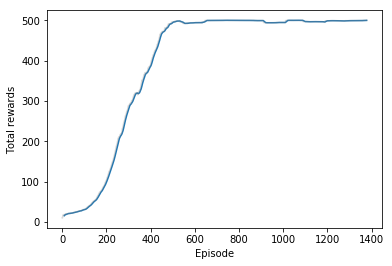

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

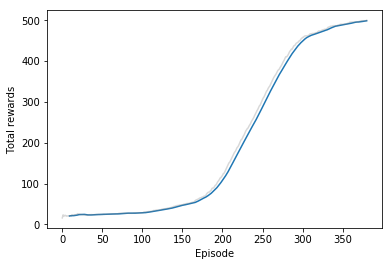

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

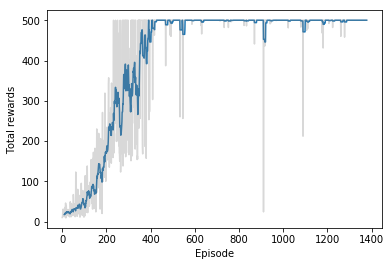

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

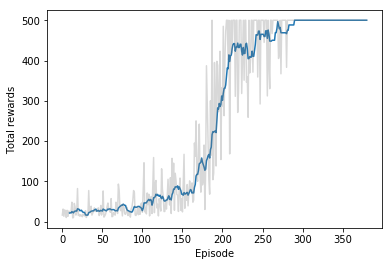

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.